# Supernova distances and redshifts (part 1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

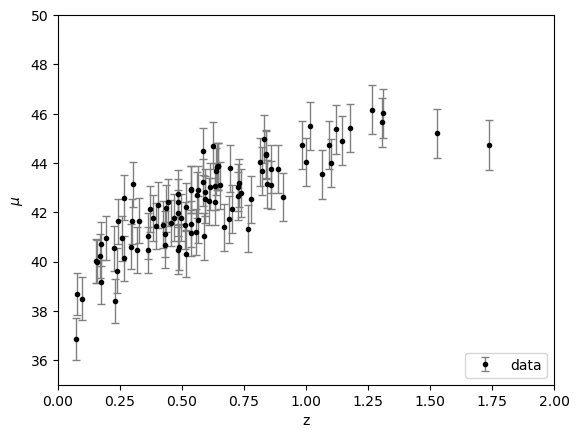

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

ndata = len(z_sample)

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Linear Regression

[39.48384602  4.76438865]


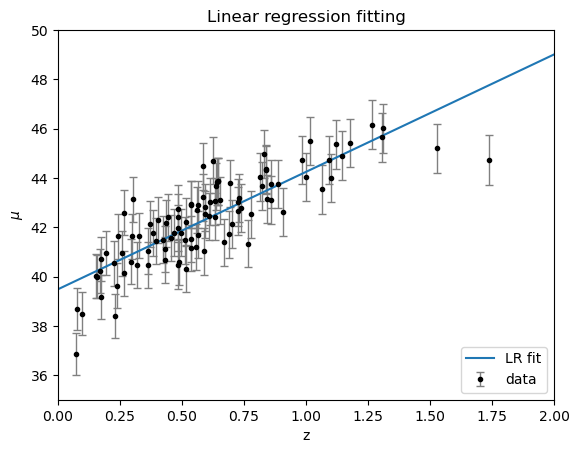

In [3]:
# diagonal noise matrix
C = np.identity(ndata) * dmu**2

# design matrix
M = np.column_stack((np.ones(ndata), z_sample))

# Sigma^-1 = M^T * C^-1 * M
A = np.dot(np.dot(M.T, np.linalg.pinv(C)), M)

# M^T * C^-1 * y
B = np.dot(np.dot(M.T, np.linalg.pinv(C)), mu_sample)

# theta = Sigma * M^T * C^-1 * y
theta = np.dot(np.linalg.pinv(A),B)
print(theta)

# plot
Xgrid = np.linspace(0,2,500)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.plot(Xgrid, theta[0]+theta[1]*Xgrid, label='LR fit')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Linear regression fitting')
plt.show()

[39.60456481] [[4.5911933]]


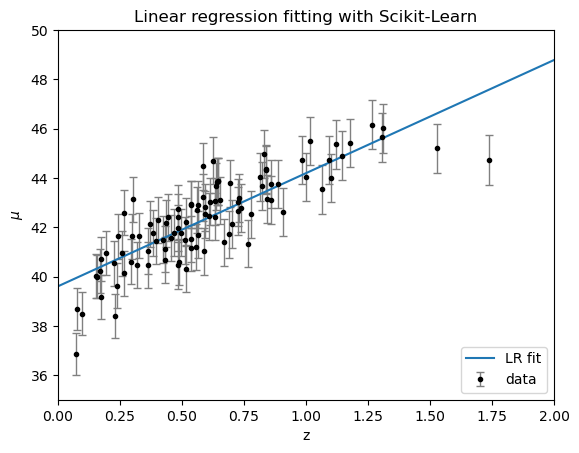

In [4]:
# Fitting with LinearRegression from Scikit-Learn 
from sklearn.linear_model import LinearRegression

X = z_sample.reshape((ndata,1))
y = mu_sample.reshape((ndata,1))
lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_
print(theta0, theta1)

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.plot(Xgrid, theta0+theta1[0]*Xgrid, label='LR fit')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Linear regression fitting with Scikit-Learn')
plt.show()

### Polynomial Regression

/home/sandokan/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


[39.56505555  4.64711848]


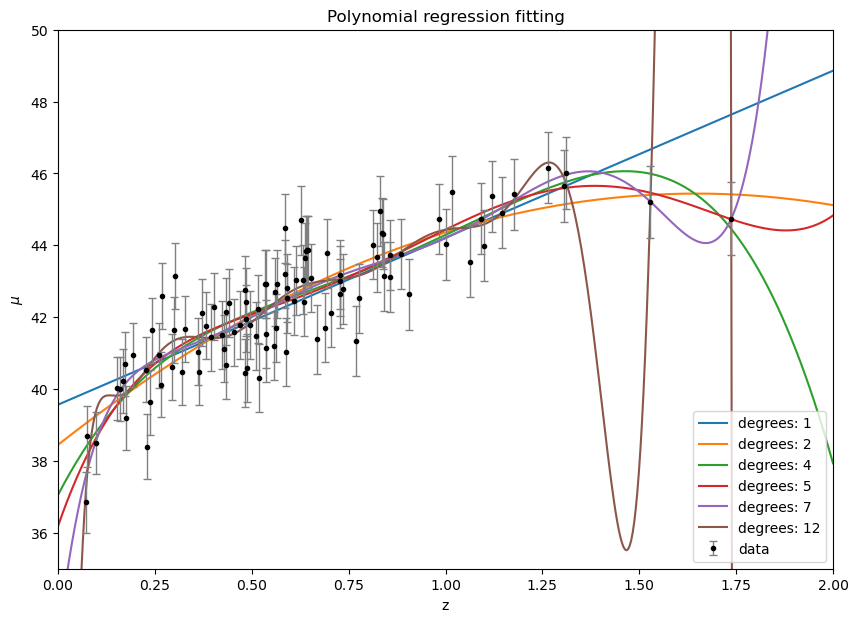

In [5]:
from astroML.linear_model import PolynomialRegression

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

def fit_function(x, n):
    f = 0
    for i in range(n+1):
        f += model.coef_[i]*x**i
    return f

degree = [1, 2, 4, 5, 7, 12]

for deg in degree:    
    model = PolynomialRegression(deg) 
    model.fit(X, mu_sample)
    y_pred = model.predict(X)

    if deg==1:
        t0 = model.coef_[0]
        t1 = model.coef_[1]
        print(model.coef_)
        
    ax.plot(Xgrid,fit_function(Xgrid,deg), label='degrees: '+str(deg))

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Polynomial regression fitting')
plt.show()

First-order polynomial underfits the data, especially at the boundaries. Polynomials of order 2, 3, 4 provide better fits, without the overfitting observed in higher-order models.

### Basis function regression

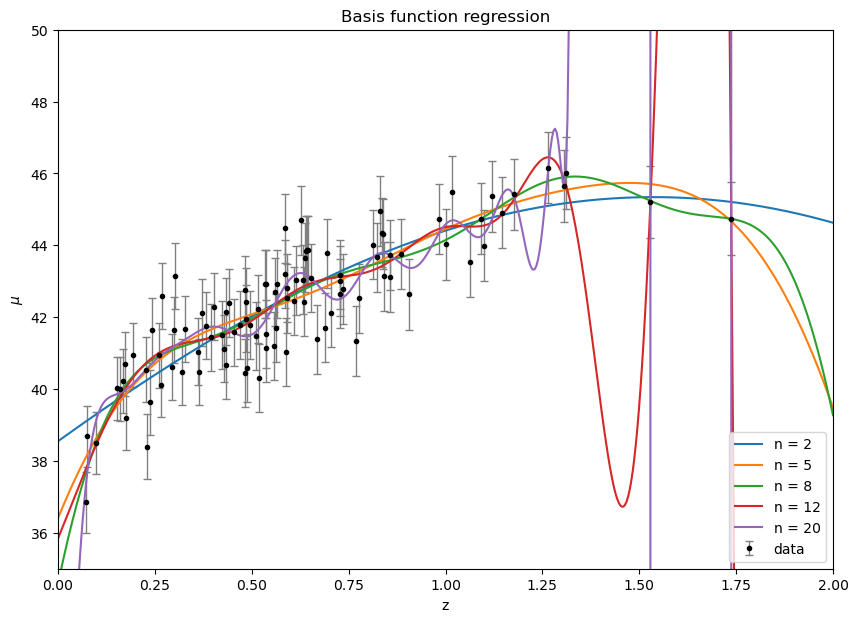

In [6]:
from astroML.linear_model import BasisFunctionRegression

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')

N = [2, 5, 8, 12, 20]

# data
X = z_sample.reshape((ndata,1))
y = mu_sample
    
for n in N:
    X_Gauss_grid = np.linspace(0,2,n)[:, None]         # mean positions of the n Gaussians in the model
    sigma = (max(X_Gauss_grid)-min(X_Gauss_grid))/(len(X_Gauss_grid)-1)     # widths of these Gaussians

    model = BasisFunctionRegression('gaussian', mu=X_Gauss_grid, sigma=sigma)
    model.fit(X, y, dmu)
    y_fit = model.predict(np.linspace(0,2,500)[:,None])
    
    ax.plot(Xgrid, y_fit, label='n = '+str(n))

plt.legend(loc='lower right')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Basis function regression')
plt.show()

### Kernel Regression

/home/sandokan/.local/lib/python3.10/site-packages/astroML/linear_model/kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


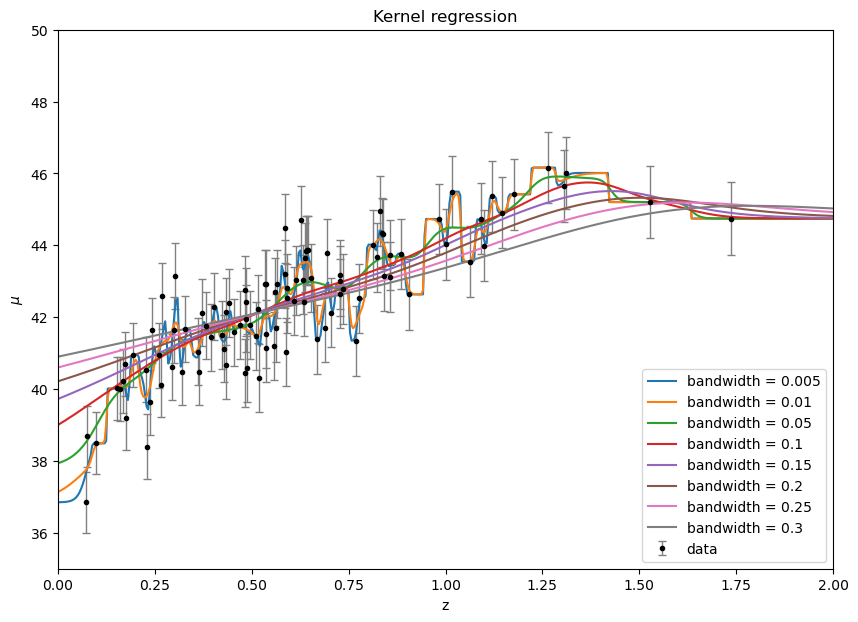

In [7]:
from astroML.linear_model import NadarayaWatson

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')

X = z_sample[:,np.newaxis]
y = mu_sample

bandwidth = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for h in bandwidth:
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(X, y)
    y_fit = model.predict(Xgrid[:,np.newaxis])

    ax.plot(Xgrid, y_fit, label='bandwidth = '+str(h))
    
plt.legend(loc='lower right')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Kernel regression')
plt.show()

### Cross validation

In [8]:
# split into training (70%) and cross-validation (30%)

from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv, dy_train, dy_cv = train_test_split(z_sample, mu_sample, dmu, test_size=0.3, random_state=43)

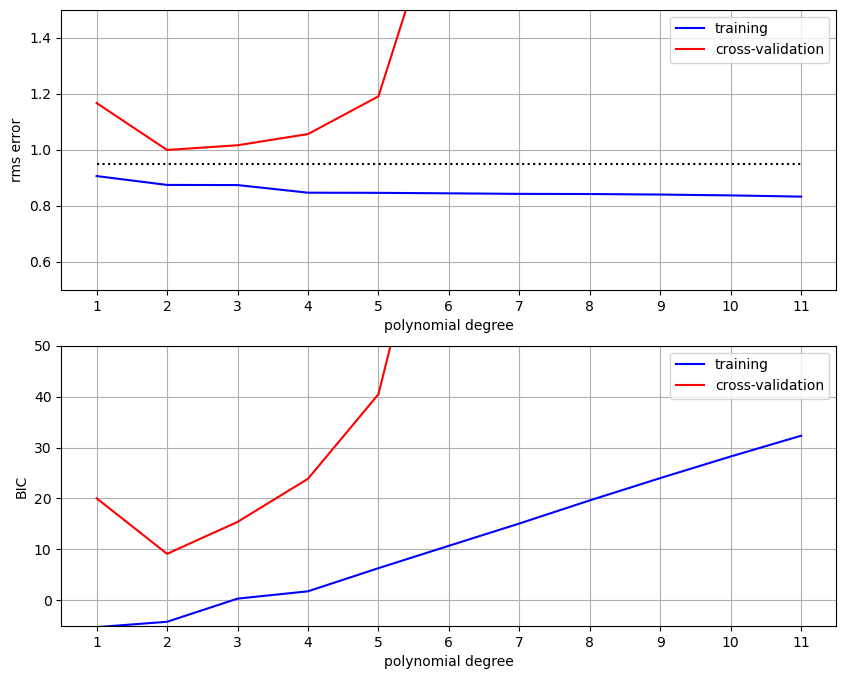

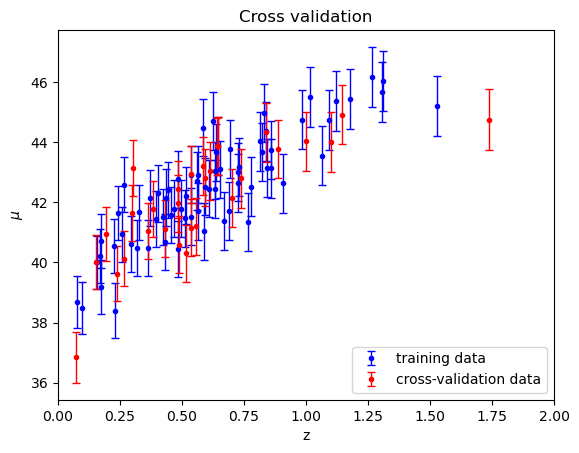

In [9]:
d = np.arange(1, 12)    # degrees of polynomials
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

for i in range(len(d)):
    p = np.polyfit(X_train, y_train, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, X_train) - y_train) ** 2) / len(y_train))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, X_cv) - y_cv) ** 2) / len(y_cv))

BIC_train    = len(y) * np.log(training_err) + d * np.log(len(y))      
BIC_crossval = len(y) * np.log(crossval_err) + d * np.log(len(y))

#______________________PLOTS_________________________

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(211)
ax.plot(d, training_err, '-b', label='training')
ax.plot(d, crossval_err, '-r', label='cross-validation')
ax.plot(d, dy_train.mean() * np.ones(d.shape), ':k')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend()
plt.grid()
plt.xticks(d)
plt.ylim(0.5,1.5)

ax = fig.add_subplot(212)
ax.plot(d, BIC_train, 'b', label='training')
ax.plot(d, BIC_crossval, 'r', label='cross-validation')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')
ax.legend()
plt.grid()
plt.xticks(d)
plt.ylim(-5,50)
plt.show()

plt.errorbar(X_train, y_train, dy_train, fmt='.b', ecolor='b', capsize=3, lw=1, label='training data')
plt.errorbar(X_cv, y_cv, dy_cv, fmt='.r', ecolor='r', capsize=3, lw=1, label='cross-validation data')
plt.legend(loc='lower right')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.title('Cross validation')
plt.show()

From the BIC and error plots, the best fit seems to be the 2nd degree polynomial. But the behaviour of the two plots may change significantly if we modify the choice of the training and C-V datasets (change random_state value in the code above). In particular, outliers at high and low redshifts play an important role, since we have very few points for these z-values. We can see it in the plots below, where we changed the initial splitting. 

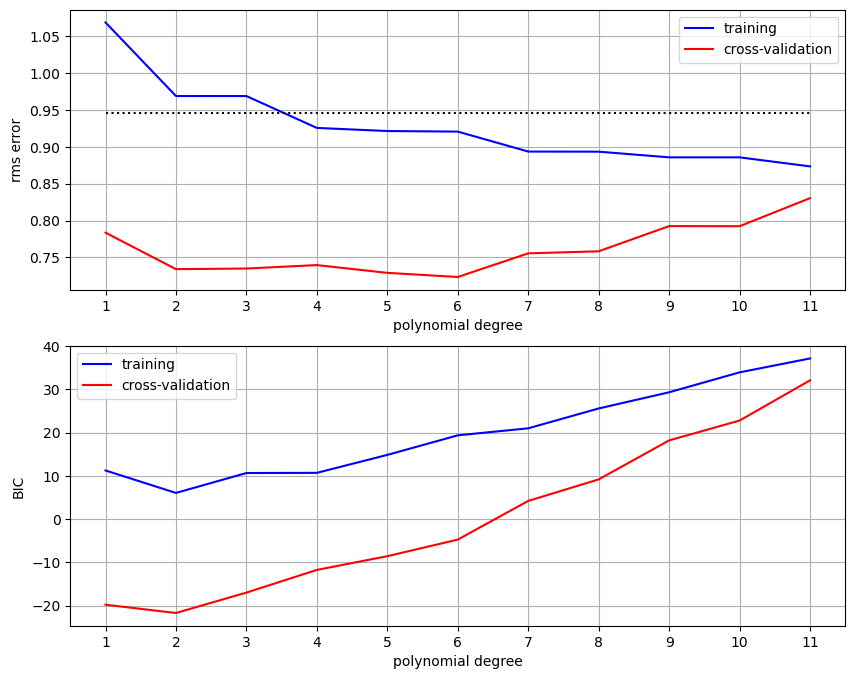

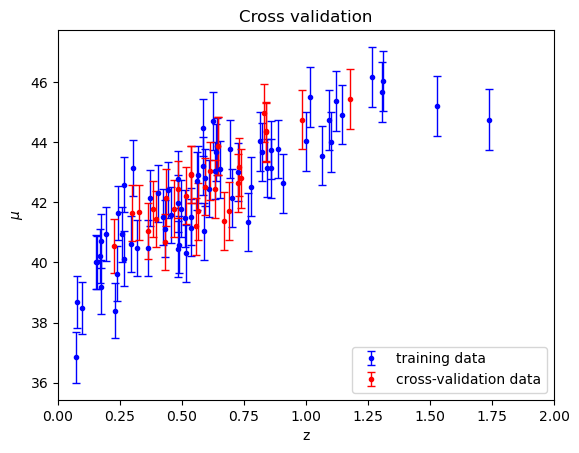

In [10]:
# split into training (70%) and cross-validation (30%)

X_train, X_cv, y_train, y_cv, dy_train, dy_cv = train_test_split(z_sample, mu_sample, dmu, test_size=0.3, random_state=2)

training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

for i in range(len(d)):
    p = np.polyfit(X_train, y_train, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, X_train) - y_train) ** 2) / len(y_train))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, X_cv) - y_cv) ** 2) / len(y_cv))

BIC_train    = len(y) * np.log(training_err) + d * np.log(len(y))      
BIC_crossval = len(y) * np.log(crossval_err) + d * np.log(len(y))

#______________________PLOTS_________________________

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(211)
ax.plot(d, training_err, '-b', label='training')
ax.plot(d, crossval_err, '-r', label='cross-validation')
ax.plot(d, dy_train.mean() * np.ones(d.shape), ':k')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend()
plt.grid()
plt.xticks(d)

ax = fig.add_subplot(212)
ax.plot(d, BIC_train, 'b', label='training')
ax.plot(d, BIC_crossval, 'r', label='cross-validation')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')
ax.legend()
plt.grid()
plt.xticks(d)
plt.show()

plt.errorbar(X_train, y_train, dy_train, fmt='.b', ecolor='b', capsize=3, lw=1, label='training data')
plt.errorbar(X_cv, y_cv, dy_cv, fmt='.r', ecolor='r', capsize=3, lw=1, label='cross-validation data')
plt.legend(loc='lower right')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.title('Cross validation')
plt.show()

To avoid this dependence on the choice of the C-V set, we repeat the procedure multiple times by shaffling the data at each run, so that the C-V and the training datasets are always different. 

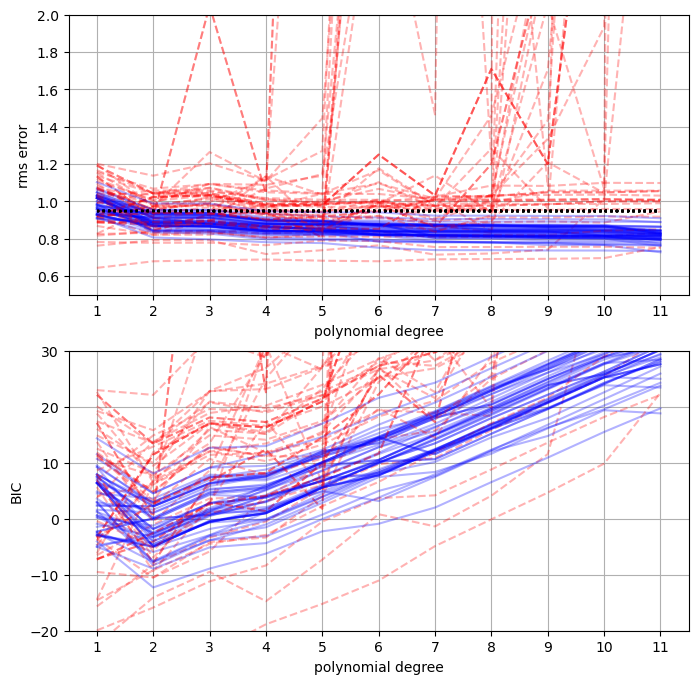

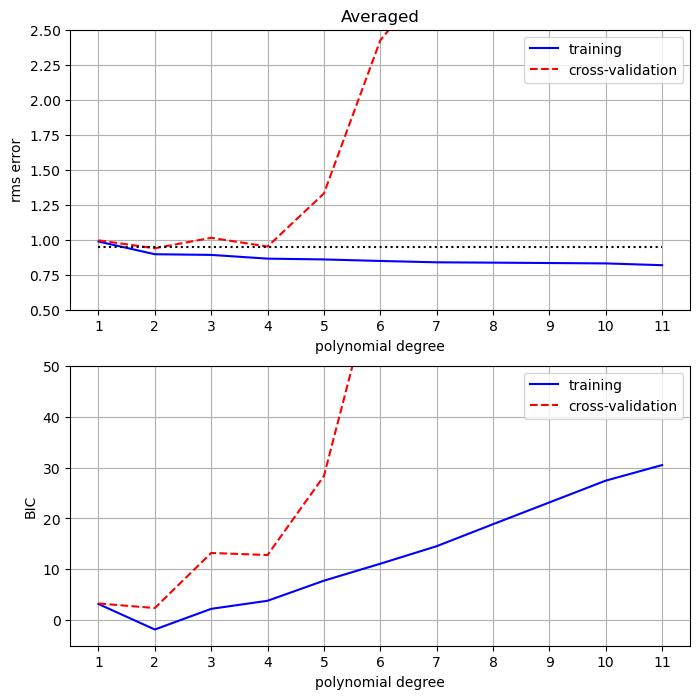

In [12]:
# Shuffling data K times 

tr_err = []
cv_err = []
BIC_tr = []
BIC_cv = []
K = 50
d = np.arange(1, 12)

for k in range(K):
    rs = np.random.randint(100)   # randomly select random_state for validation-train splitting
    X_train, X_cv, y_train, y_cv, dy_train, dy_cv = train_test_split(z_sample, mu_sample, dmu, test_size=0.3, random_state=rs)
    
    training_err = np.zeros(d.shape)
    crossval_err = np.zeros(d.shape)

    for i in range(len(d)):
        p = np.polyfit(X_train, y_train, d[i])
        training_err[i] = np.sqrt(np.sum((np.polyval(p, X_train) - y_train) ** 2) / len(y_train))
        crossval_err[i] = np.sqrt(np.sum((np.polyval(p, X_cv) - y_cv) ** 2) / len(y_cv))

    tr_err.append(training_err)
    cv_err.append(crossval_err)
    BIC_tr.append(len(y) * np.log(training_err) + d * np.log(len(y)))
    BIC_cv.append(len(y) * np.log(crossval_err) + d * np.log(len(y)))

#______________________PLOTS_________________________

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(211)
for i in range(K):
    ax.plot(d, tr_err[i], '-b', alpha=0.3, label='training')
    ax.plot(d, cv_err[i], '--r', alpha=0.3, label='cross-validation')
    ax.plot(d, dy_train.mean() * np.ones(d.shape), ':k')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
plt.grid()
plt.xticks(d)
plt.ylim(0.5,2)

ax = fig.add_subplot(212)
for i in range(K):
    ax.plot(d, BIC_tr[i], 'b', alpha=0.3, label='training')
    ax.plot(d, BIC_cv[i], 'r--', alpha=0.3, label='cross-validation')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')
plt.grid()
plt.xticks(d)
plt.ylim(-20,30)

plt.show()

#______________________________________________________________
tr_errM = []
cv_errM = []
BIC_trM = []
BIC_cvM = []
for i in range(len(d)):
    tr_errM.append( np.mean(np.array(tr_err).T[i]) )
    cv_errM.append( np.mean(np.array(cv_err).T[i]) )
    BIC_trM.append( np.mean(np.array(BIC_tr).T[i]) )
    BIC_cvM.append( np.mean(np.array(BIC_cv).T[i]) )

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(211)
ax.set_title('Averaged')
ax.plot(d, tr_errM, '-b', label='training')
ax.plot(d, cv_errM, '--r', label='cross-validation')
ax.plot(d, dy_train.mean() * np.ones(d.shape), ':k')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
plt.grid()
plt.legend()
plt.xticks(d)
plt.ylim(0.5,2.5)

ax = fig.add_subplot(212)
ax.plot(d, BIC_trM, 'b', label='training')
ax.plot(d, BIC_cvM, 'r--', label='cross-validation')
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')
plt.grid()
plt.legend()
plt.xticks(d)
plt.ylim(-5,50)
plt.show()

The last two plots show the RMS error and BIC averaged over the K results. The best fit corresponds to a 2nd degree polynomial, but now we are not influenced by the datasets choice. 

While the BIC plot prefers the 2nd degree polynomial, the error plot admit also 3rd and 4th orders, as we had previously guessed based on a rough visual estimate.

Note that, as the degree of the polynomial increases, both the RMS error and the BIC of the validation sets increase significantly, indicating overfitting.